## **Anytime Active Learning**

The following algorithm is based on the **2014 AAAI** Conference Processdings on *Anytime Active Learning *
https://cdn.aaai.org/ojs/9015/9015-13-12543-1-2-20201228.pdf

## Importing Libraries

The following libraries/modules are required for natural language preprocessing as well as trainnig the logistic regression model.

In [1]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from nltk.probability import FreqDist
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import pickle
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

### Utility Functions

Function for counting the number of words in each document

In [2]:
def word_count(s):
    return len(s.split())

Function to remove any html tags <> </> present in the document text

In [3]:
def striphtml(text):
    p=re.compile('<.*?>')
    return p.sub('',text)

Mounting the Drive (for accessing the data)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading the data stored in the drive (the dataset needs to be first stored in the drive and then the path of the dataset file should be mentioned here)

The dataset can be used from: https://drive.google.com/file/d/1eB1gnQlWNnlTtFDPUXQP89axziHX-a5w/view?usp=sharing

In [6]:
df = pd.read_csv("/content/drive/MyDrive/Twitter Dataset.csv")

Checking the number of rows and columns in the data: Two columns - one containing the document samples (reviews) and the other containing the binary labels for the sentiment of the reviews (positive or negative)

In [7]:
df.shape

(7920, 3)

In [8]:
df.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


Removing the html tag from the data

In [9]:
df['tweet'] = df['tweet'].apply(striphtml)

Converting all the review text documents to lowercase

In [10]:
df['tweet'] = df['tweet'].str.lower()

In [11]:
df.shape

(7920, 3)

Splitting the dataset into two equal halves in order to use separate data for training the oracle simulation and pretrained classifier

In [12]:
midpoint = len(df) // 2
df1 = df.iloc[:midpoint]
df2 = df.iloc[midpoint:]

In order to save the CPU RAM, models can be pickled and stored to be reloaded at the time of use. In order to store and retrieve the models in Google Drive, the following authentication instance need to be created

In [13]:
# Authenticate and create a GoogleDrive instance
gauth = GoogleAuth()
drive = GoogleDrive(gauth)

Converting text to numeric vectors with n grams stemming of 1 to 3 using the scikit learn countvectorizer

In [14]:
cv = CountVectorizer(lowercase=True,ngram_range=(1, 3))

considering the entire first half of the dataset for oracle trainng and testing

In [15]:
sampled_data = df1
# n can be changed as required

Converting the textual sentiment labels into encoded numeric values

In [16]:
y=sampled_data['label']
encoder = LabelEncoder()
y=encoder.fit_transform(y)

Performing train-test split (50%)

In [17]:
X_train,X_test,y_train,y_test = train_test_split(sampled_data['tweet'],y,test_size=0.5,random_state=1)

In [18]:
y_train.shape

(1980,)

Vectorizing the training set documents

In [19]:
X_train_bow = cv.fit_transform(X_train).toarray()

In [20]:
X_train_bow.shape

(1980, 59692)

Training the logistic regression classifier from scikitlearn as the oracle with L2 regularization and penalty score C = 0.01 (as mentioned in the paper) and for bi class classification, setting multi_class to 'ovr'

In [21]:
oracle = LogisticRegression(penalty='l2', C=0.01, multi_class='ovr').fit(X_train_bow, y_train)

In [22]:
# # Pickle and save the model
# with open('oracle.pkl', 'wb') as model_file:
#     pickle.dump(oracle, model_file)

Function to simulate oracle behaviour (oracle assigns label to document only if it is atleast 60% certain, uncertainty threshold =0.4 as mentioned in the paper)

In [23]:
def answer(oracle,x):
    if 1 - max(oracle.predict_proba(x)[0]) > 0.4:return -1
    return oracle.predict(x)[0]

## **Anytime Active Learning**



## Static AAL

**Utility Functions**

Uncertainty function U(Xi) that outputs the uncertainty of classifier (=1-probability_of_prediction) for a given sample/set of samples Xi

In [24]:
def static_k_unc(Xik,PretrainedClassifier):
  return 1-PretrainedClassifier.predict_proba(Xik)

Static constant utility function that is always constant (=1)

In [25]:
def static_k_const(Xik,PretrainedClassifier):
  return 1

Function to generate Uk - the set of unlabelled samples with documents truncated at k words, from the entire unlabelled dataset U with complete/non-truncated documents

In [26]:
def generate_Uk(U,k):
  U = U.apply(lambda x: ' '.join(x.split()[:k]))
  return cv.transform(U).toarray()

Sampling 2400 documents from the second half of the dataset to train and test the pretrained classifier

In [27]:
sampled_data = df2.sample(n=2400, random_state=14)

Encoding the sentiment labels

In [28]:
encoder = LabelEncoder()
y=encoder.fit_transform(sampled_data.label)

Performing train-test split (50%), less amount of data is chosen to train to replicate the condition that very small amount of labelled data is available for supervised learning)

In [29]:
X_train,X_test,y_train,y_test = train_test_split(sampled_data['tweet'],y,test_size=0.5,random_state=1)

Vectorizing the train and test sample documents

In [30]:
X_train_bow = cv.fit_transform(X_train).toarray()

In [31]:
X_test_bow = cv.transform(X_test).toarray()

Defining the select subinstance function that returnss the sample for which the ratio of utility/benefit to cost is maximum

In [32]:
def select_subinstance(U,classifier):
  return np.argmin(classifier.decision_function(U))

Considering the test data samples and the unlabelled dataset U from which samples are drawn for annotation

In [33]:
U = X_test_bow

In [34]:
k = 10

In [35]:
Uk = generate_Uk(X_test,k)

In [36]:
PretrainedClassifier = LogisticRegression(penalty='l2', C=0.01, multi_class='ovr').fit(X_train_bow, y_train)

In [37]:
L = X_train_bow

In [38]:
C={10:5.7,25:8.2,50:10.9,75:15.9,100:16.7}

In [39]:
Ck = C[k]

Loading the pickled oracle model from drive

In [40]:
# with open('oracle.pkl', 'rb') as model_file:
#     oracle = pickle.load(model_file)

In [41]:
L.shape

(1200, 37999)

In [42]:
y_train.shape

(1200,)

In [43]:
U.shape

(1200, 37999)

Initializing the area under curve AUC and cost arrays to obtain the learning curve for AAL

In [44]:
auc=[]
cost=[]

Applying the static AAL algorithm according to 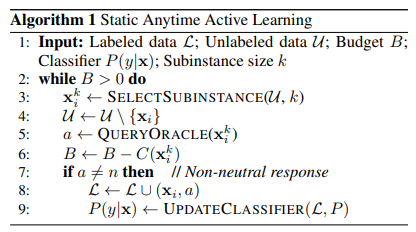

In [45]:
# Budget of 50 minutes
B = 3000
while B>0:
  print(B)
  index = select_subinstance(U,PretrainedClassifier)
  Xik = Uk[index]
  Xi = U[index]
  U=np.concatenate((U[:index], U[index + 1:]))
  a = answer(PretrainedClassifier,[Xik])
  B = B - Ck
  if a!=-1:
    L = np.concatenate((L, [Xi]))
    y_train = np.concatenate((y_train,[a]))
    PretrainedClassifier.fit(L, y_train)
    X_test_bow = cv.transform(X_test).toarray()
    y_test_pred = PretrainedClassifier.predict_proba(X_test_bow)[:, 1]
    auc.append(roc_auc_score(y_test, y_test_pred))
    cost.append(3000-B)

3000
2994.3
2988.6000000000004
2982.9000000000005
2977.2000000000007
2971.500000000001
2965.800000000001
2960.1000000000013
2954.4000000000015
2948.7000000000016
2943.000000000002
2937.300000000002
2931.600000000002
2925.9000000000024
2920.2000000000025
2914.5000000000027
2908.800000000003
2903.100000000003
2897.4000000000033
2891.7000000000035
2886.0000000000036
2880.300000000004
2874.600000000004
2868.900000000004
2863.2000000000044
2857.5000000000045
2851.8000000000047
2846.100000000005
2840.400000000005
2834.7000000000053
2829.0000000000055
2823.3000000000056
2817.600000000006
2811.900000000006
2806.200000000006
2800.5000000000064
2794.8000000000065
2789.1000000000067
2783.400000000007
2777.700000000007
2772.0000000000073
2766.3000000000075
2760.6000000000076
2754.900000000008
2749.200000000008
2743.500000000008
2737.8000000000084
2732.1000000000085
2726.4000000000087
2720.700000000009
2715.000000000009
2709.3000000000093
2703.6000000000095
2697.9000000000096
2692.20000000001
2686.

Plotting the learnig curve for k = 10

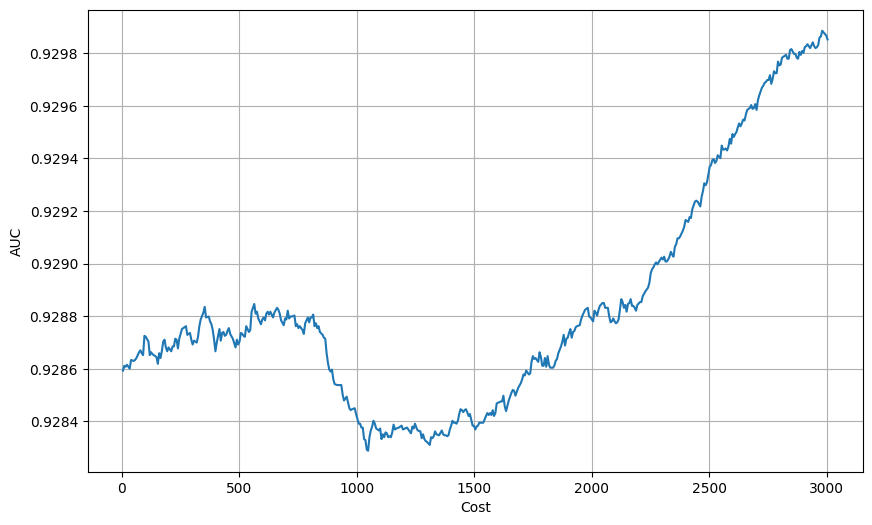

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(cost[::-1], auc)
plt.xlabel("Cost")
plt.ylabel("AUC")
plt.grid(True)
plt.show()

Repeating the entire process for conventional pool based active learning

In [47]:
sampled_data = df2.sample(n=2400, random_state=14)

In [48]:
encoder = LabelEncoder()
y=encoder.fit_transform(sampled_data.label)

In [49]:
X_train,X_test,y_train,y_test = train_test_split(sampled_data['tweet'],y,test_size=0.5,random_state=1)

In [50]:
X_train_bow = cv.fit_transform(X_train).toarray()

In [51]:
X_test_bow = cv.transform(X_test).toarray()

In [52]:
U = X_test_bow

In [53]:
L = X_train_bow

In [54]:
PretrainedClassifier = LogisticRegression(penalty='l2', C=0.01, multi_class='ovr').fit(X_train_bow, y_train)

In [ ]:
# Budget of 50 minutes
auc2=[]
cost2=[]
def answer2(oracle,x):
    return oracle.predict(x)[0]
B = 3000
while B>0:
  print(B)
  index = select_subinstance(U,PretrainedClassifier)
  Xi = U[index]
  U=np.concatenate((U[:index], U[index + 1:]))
  a = answer2(PretrainedClassifier,[Xi])
  B = B - 15
  L = np.concatenate((L, [Xi]))
  y_train = np.concatenate((y_train,[a]))
  PretrainedClassifier.fit(L, y_train)
  X_test_bow = cv.transform(X_test).toarray()
  y_test_pred = PretrainedClassifier.predict_proba(X_test_bow)[:, 1]
  auc2.append(roc_auc_score(y_test, y_test_pred))
  cost2.append(3000-B)

3000
2985
2970
2955
2940
2925
2910
2895
2880
2865
2850
2835
2820
2805
2790
2775
2760
2745
2730
2715
2700
2685
2670
2655
2640
2625
2610
2595
2580
2565
2550
2535
2520
2505
2490
2475
2460
2445
2430
2415
2400
2385
2370
2355
2340
2325
2310
2295
2280
2265
2250
2235
2220
2205
2190
2175
2160
2145
2130
2115
2100
2085
2070
2055
2040
2025
2010
1995
1980
1965
1950
1935
1920
1905
1890
1875
1860
1845
1830
1815
1800
1785
1770
1755
1740
1725
1710
1695
1680
1665
1650
1635
1620
1605
1590
1575
1560
1545
1530
1515
1500
1485
1470
1455
1440
1425
1410
1395
1380
1365
1350
1335
1320
1305
1290
1275
1260
1245
1230
1215
1200
1185
1170
1155
1140
1125
1110
1095
1080
1065
1050
1035
1020
1005
990
975
960
945
930
915
900
885
870
855
840
825
810
795
780
765
750
735
720
705
690
675
660
645
630
615
600
585
570
555
540
525
510
495
480
465
450
435
420
405
390
375
360
345
330
315
300
285
270
255
240
225
210
195
180
165
150
135
120
105
90
75


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cost2[::-1], auc2)
plt.xlabel("Cost")
plt.ylabel("AUC")
plt.grid(True)
plt.show()

Comparing the plots for AAL k = 10 and AL (active learning)

In [ ]:
# Plot x1 vs y1
plt.plot(cost[::-1], auc, label='AAL',  linestyle='-', color='blue',linewidth=1)

# Plot x2 vs y2
plt.plot(cost2[::-1], auc2, label='AL', linestyle='--', color='red',linewidth=1)

# Add labels, title, and legend
plt.xlabel('cost')
plt.ylabel('AUC')
plt.legend()
# Show the plot
plt.show()

Repeating the entire process for k=25

In [ ]:
sampled_data = df2.sample(n=2400, random_state=14)

In [59]:
encoder = LabelEncoder()
y=encoder.fit_transform(sampled_data.label)

In [60]:
X_train,X_test,y_train,y_test = train_test_split(sampled_data['tweet'],y,test_size=0.5,random_state=1)

In [61]:
X_train_bow = cv.fit_transform(X_train).toarray()

In [62]:
X_test_bow = cv.transform(X_test).toarray()

In [63]:
U = X_test_bow

In [64]:
L = X_train_bow

In [65]:
k = 25

In [66]:
Uk = generate_Uk(X_test,k)

In [67]:
PretrainedClassifier = LogisticRegression(penalty='l2', C=0.01, multi_class='ovr').fit(X_train_bow, y_train)

In [68]:
# Budget of 50 minutes
auc3=[]
cost3=[]
def answer2(oracle,x):
    return oracle.predict(x)[0]
B = 3000
while B>0:
  print(B)
  index = select_subinstance(U,PretrainedClassifier)
  Xi = U[index]
  U=np.concatenate((U[:index], U[index + 1:]))
  a = answer2(PretrainedClassifier,[Xi])
  B = B - 8.2
  L = np.concatenate((L, [Xi]))
  y_train = np.concatenate((y_train,[a]))
  PretrainedClassifier.fit(L, y_train)
  X_test_bow = cv.transform(X_test).toarray()
  y_test_pred = PretrainedClassifier.predict_proba(X_test_bow)[:, 1]
  auc3.append(roc_auc_score(y_test, y_test_pred))
  cost3.append(3000-B)

3000
2991.8
2983.6000000000004
2975.4000000000005
2967.2000000000007
2959.000000000001
2950.800000000001
2942.6000000000013
2934.4000000000015
2926.2000000000016
2918.000000000002
2909.800000000002
2901.600000000002
2893.4000000000024
2885.2000000000025
2877.0000000000027
2868.800000000003
2860.600000000003
2852.4000000000033
2844.2000000000035
2836.0000000000036
2827.800000000004
2819.600000000004
2811.400000000004
2803.2000000000044
2795.0000000000045
2786.8000000000047
2778.600000000005
2770.400000000005
2762.2000000000053
2754.0000000000055
2745.8000000000056
2737.600000000006
2729.400000000006
2721.200000000006
2713.0000000000064
2704.8000000000065
2696.6000000000067
2688.400000000007
2680.200000000007
2672.0000000000073
2663.8000000000075
2655.6000000000076
2647.400000000008
2639.200000000008
2631.000000000008
2622.8000000000084
2614.6000000000085
2606.4000000000087
2598.200000000009
2590.000000000009
2581.8000000000093
2573.6000000000095
2565.4000000000096
2557.20000000001
2549.

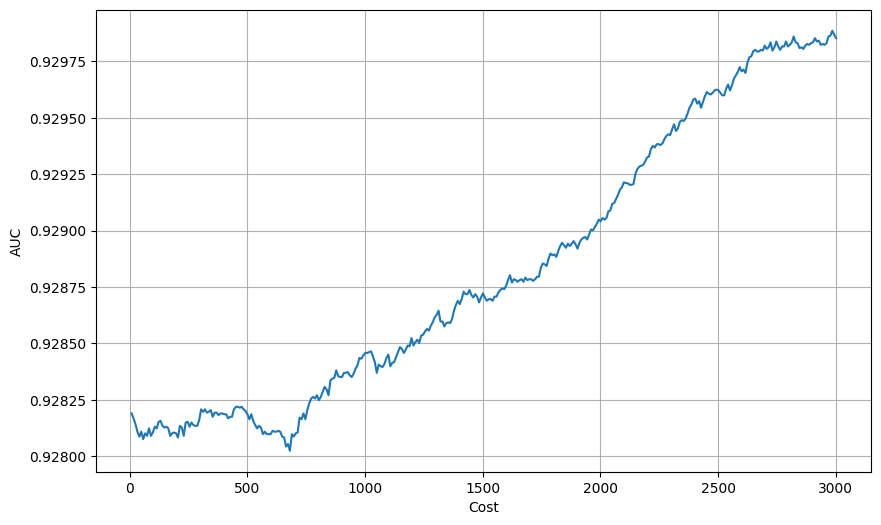

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(cost3[::-1], auc3)
plt.xlabel("Cost")
plt.ylabel("AUC")
plt.grid(True)
plt.show()

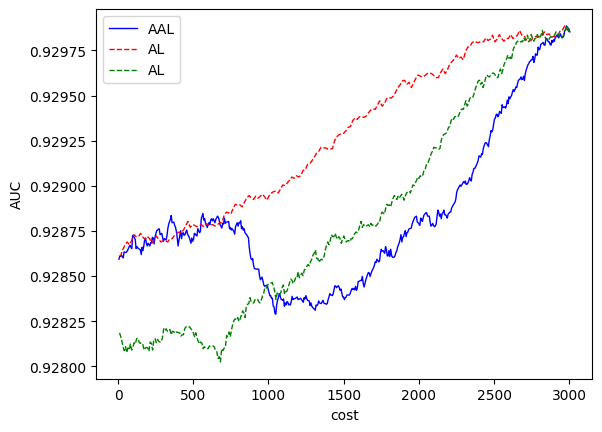

In [84]:
# Plot x1 vs y1
plt.plot(cost[::-1], auc, label='AAL',  linestyle='-', color='blue',linewidth=1)

# Plot x2 vs y2
plt.plot(cost2[::-1], auc2, label='AL', linestyle='--', color='red',linewidth=1)

# Plot x3 vs y3
plt.plot(cost3[::-1], auc3, label='AL', linestyle='--', color='green',linewidth=1)

# Add labels, title, and legend
plt.xlabel('cost')
plt.ylabel('AUC')
plt.legend()
# Show the plot
plt.show()

Repeating the entire process for k=25

In [71]:
sampled_data = df2.sample(n=2400, random_state=14)

In [72]:
encoder = LabelEncoder()
y=encoder.fit_transform(sampled_data.label)

In [73]:
X_train,X_test,y_train,y_test = train_test_split(sampled_data['tweet'],y,test_size=0.5,random_state=1)

In [74]:
X_train_bow = cv.fit_transform(X_train).toarray()

In [75]:
X_test_bow = cv.transform(X_test).toarray()

In [76]:
U = X_test_bow

In [77]:
L = X_train_bow

In [78]:
k = 100

In [79]:
Uk = generate_Uk(X_test,k)

In [80]:
PretrainedClassifier = LogisticRegression(penalty='l2', C=0.01, multi_class='ovr').fit(X_train_bow, y_train)

In [81]:
# Budget of 50 minutes
auc4=[]
cost4=[]
def answer2(oracle,x):
    return oracle.predict(x)[0]
B = 3000
while B>0:
  print(B)
  index = select_subinstance(U,PretrainedClassifier)
  Xi = U[index]
  U=np.concatenate((U[:index], U[index + 1:]))
  a = answer2(PretrainedClassifier,[Xi])
  B = B - 16.7
  L = np.concatenate((L, [Xi]))
  y_train = np.concatenate((y_train,[a]))
  PretrainedClassifier.fit(L, y_train)
  X_test_bow = cv.transform(X_test).toarray()
  y_test_pred = PretrainedClassifier.predict_proba(X_test_bow)[:, 1]
  auc4.append(roc_auc_score(y_test, y_test_pred))
  cost4.append(3000-B)

3000
2983.3
2966.6000000000004
2949.9000000000005
2933.2000000000007
2916.500000000001
2899.800000000001
2883.1000000000013
2866.4000000000015
2849.7000000000016
2833.000000000002
2816.300000000002
2799.600000000002
2782.9000000000024
2766.2000000000025
2749.5000000000027
2732.800000000003
2716.100000000003
2699.4000000000033
2682.7000000000035
2666.0000000000036
2649.300000000004
2632.600000000004
2615.900000000004
2599.2000000000044
2582.5000000000045
2565.8000000000047
2549.100000000005
2532.400000000005
2515.7000000000053
2499.0000000000055
2482.3000000000056
2465.600000000006
2448.900000000006
2432.200000000006
2415.5000000000064
2398.8000000000065
2382.1000000000067
2365.400000000007
2348.700000000007
2332.0000000000073
2315.3000000000075
2298.6000000000076
2281.900000000008
2265.200000000008
2248.500000000008
2231.8000000000084
2215.1000000000085
2198.4000000000087
2181.700000000009
2165.000000000009
2148.3000000000093
2131.6000000000095
2114.9000000000096
2098.20000000001
2081.

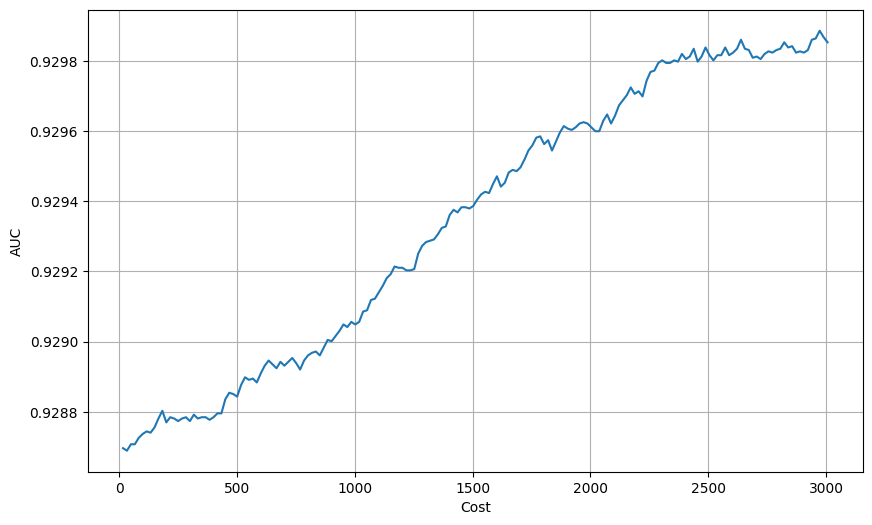

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(cost4[::-1], auc4)
plt.xlabel("Cost")
plt.ylabel("AUC")
plt.grid(True)
plt.show()

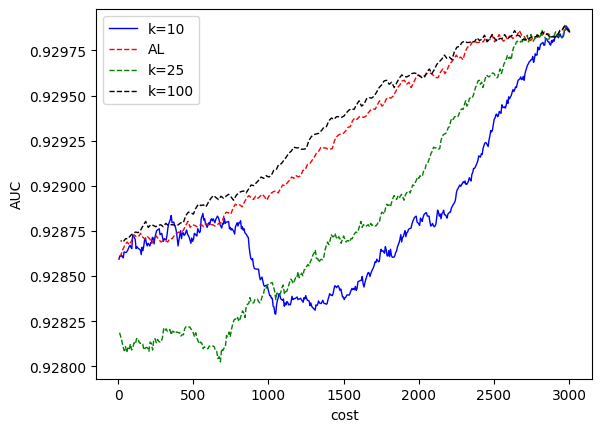

In [87]:
# Plot x1 vs y1
plt.plot(cost[::-1], auc, label='k=10',  linestyle='-', color='blue',linewidth=1)

# Plot x2 vs y2
plt.plot(cost2[::-1], auc2, label='AL', linestyle='--', color='red',linewidth=1)

# Plot x3 vs y3
plt.plot(cost3[::-1], auc3, label='k=25', linestyle='--', color='green',linewidth=1)

# Plot x4 vs y4
plt.plot(cost4[::-1], auc4, label='k=100', linestyle='--', color='black',linewidth=1)

# Add labels, title, and legend
plt.xlabel('cost')
plt.ylabel('AUC')
plt.legend()
# Show the plot
plt.show()